Cifar-10 Image distribution

In [1]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from lib import forward_diffusion, reverse_diffusion, DDPM, make_schedule
from lib_ddrm import DDRM
from unet import UNetModel
from torchvision.transforms import ToTensor, Compose, PILToTensor, Normalize
import os
from PIL import Image

In [2]:
#Download Cifar10
#cifar10_dataset_root = '/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/datasets/cifar10'
#cifar10_dataset = CIFAR10(root=cifar10_dataset_root, download=True)

N=50000 train samples in cifar10


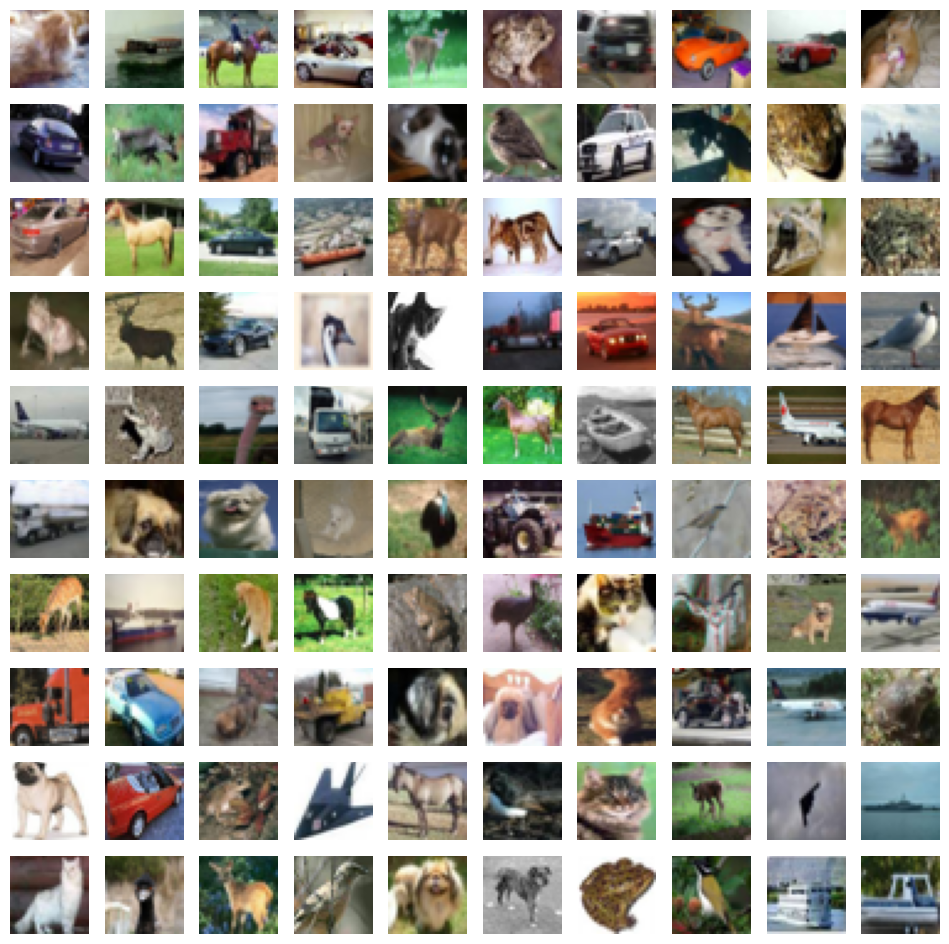

In [3]:
#Visualize Cifar10 images
cifar10_dataset_root = '/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/datasets/cifar10'
cifar10_train_dataset_orig = CIFAR10(root=cifar10_dataset_root, download=False, train=True)
N = len(cifar10_train_dataset_orig)
print(f"N={N} train samples in cifar10")
num_samples = 100
h, w = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
assert h*w == num_samples
f, ax = plt.subplots(ncols=w, nrows=h, figsize=(1.2*w,1.2*h))
samples = np.random.choice(np.arange(N),size=num_samples)
for id, sample in enumerate(samples):
    (image, target) = cifar10_train_dataset_orig[sample]
    image = np.array(image)
    r = id//w
    c = id - (r*w)
    ax[r,c].imshow(image)
    ax[r,c].axis('off')

Text(0.5, 0, 'rvar')

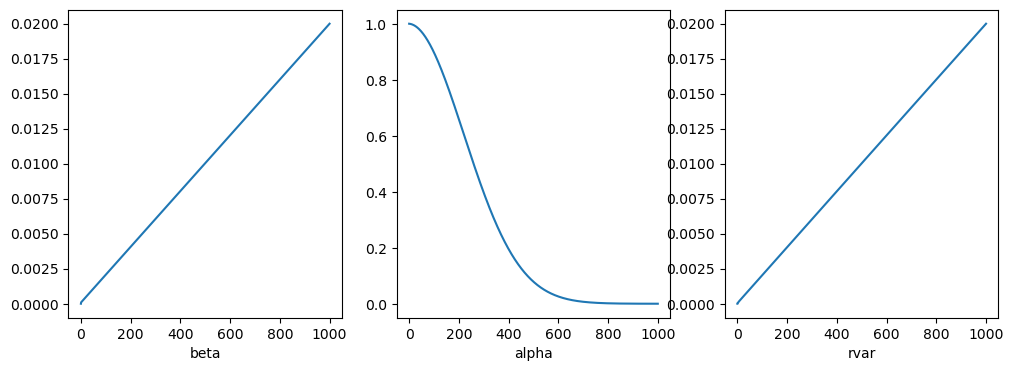

In [4]:
T = 1000
schedule = make_schedule(scheme='linear', rvar='fvar', T=T, start_beta=1e-4, end_beta=2e-2)
f, ax = plt.subplots(ncols=3,figsize=(12,4))
ax[0].plot(np.arange(start=0,stop=T+1),schedule['beta'])
ax[0].set_xlabel('beta')
ax[1].plot(np.arange(start=0,stop=T+1),schedule['alpha'])
ax[1].set_xlabel('alpha')
ax[2].plot(np.arange(start=0,stop=T+1),schedule['rvar'])
ax[2].set_xlabel('rvar')
#print(schedule['alpha'])

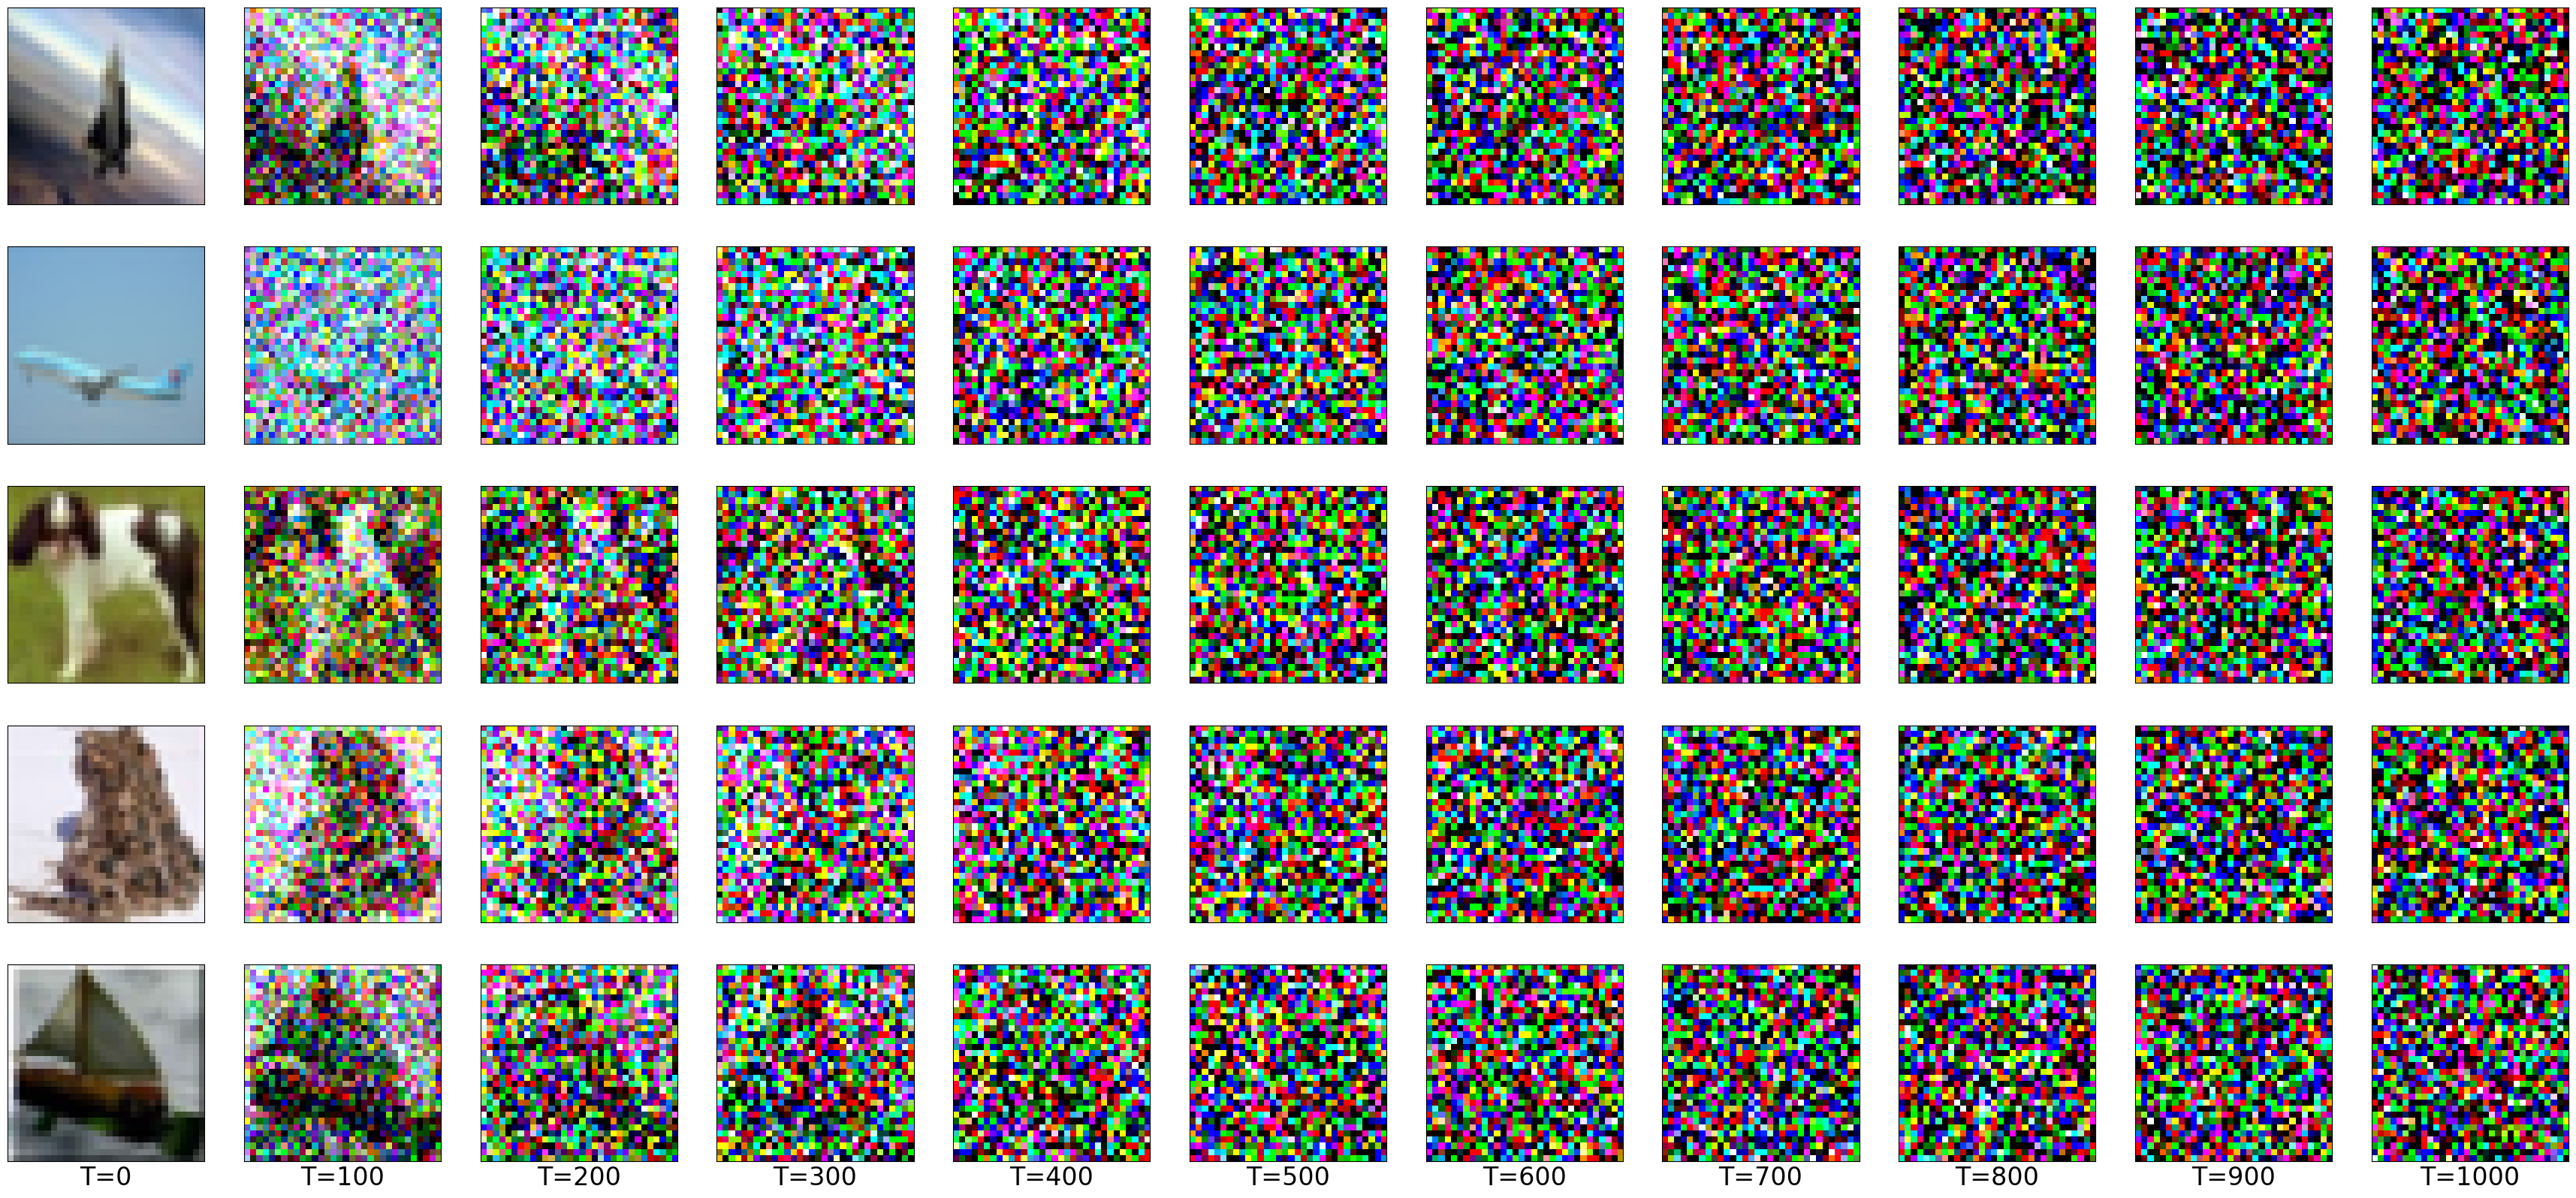

In [5]:
numtime = 11
numsamples = 5
f, ax = plt.subplots(ncols=numtime, nrows=numsamples, figsize=(4*numtime,4*numsamples))
samples = np.random.choice(np.arange(len(cifar10_train_dataset_orig)),size=numsamples)
for idx,t in enumerate(np.linspace(start=0, stop=T, endpoint=True, num=numtime)):
    t = int(t)
    for idy, sample in enumerate(samples):
        (image, target) = cifar10_train_dataset_orig[sample]
        image = np.array(image, dtype=np.float32)/255.0
        #image = np.array(image)
        image_t = forward_diffusion(image, 0, t, schedule)
        ax[idy, idx].imshow(np.asarray(np.clip(image_t*255,a_min=0,a_max=255),dtype=np.uint8))    
        #ax[idy, idx].set_xlabel('T='+str(t))
        ax[idy, idx].set_xticks([])
        ax[idy, idx].set_yticks([])
        if idy == len(samples)-1:
            ax[idy, idx].set_xlabel('T='+str(t), fontsize=24)

In [6]:
class unet_cifar10_classic(torch.nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        self.model = UNetModel(image_size=32,
                            in_channels=3,
                            model_channels=128,
                            out_channels=3,
                            num_res_blocks=2,
                            attention_resolutions=[2],
                            dropout=0.1,
                            channel_mult=(1, 2, 2, 2),
                            conv_resample=True,
                            dims=2,
                            num_classes=None,
                            use_checkpoint=False,
                            use_fp16=False,
                            num_heads=1,
                            num_head_channels=-1,
                            num_heads_upsample=-1,
                            use_scale_shift_norm=False,
                            resblock_updown=False,
                            use_new_attention_order=False)
        """
        self.model = UNetModel(image_size=32,
                            in_channels=3,
                            model_channels=128,
                            out_channels=3,
                            num_res_blocks=2,
                            attention_resolutions=[2,4],
                            dropout=0,
                            channel_mult=(1, 2, 4, 8),
                            conv_resample=True,
                            dims=2,
                            num_classes=None,
                            use_checkpoint=False,
                            use_fp16=False,
                            num_heads=1,
                            num_head_channels=-1,
                            num_heads_upsample=-1,
                            use_scale_shift_norm=False,
                            resblock_updown=False,
                            use_new_attention_order=False)
        """

    def forward(self, x, t):
        return self.model(x, t)

def train(ddpm_model, num_epochs, batch_size, savefreq, prefix):
    optimizer = torch.optim.Adam(ddpm_model.model.parameters(),lr=2e-4)
    cifar10_train_dataset = CIFAR10(root=cifar10_dataset_root, download=False, train=True, transform=Compose([ToTensor(), Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])  ]))
    dataloader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1,num_epochs+1):
        LOSS = 0
        ITER = 0
        for data in dataloader:
            data_x, data_y = data
            optimizer.zero_grad()
            loss = ddpm_model.run_step(data_x)
            loss.backward()
            optimizer.step()
            LOSS += loss.item()
            ITER += 1
        print(f"epoch = {epoch}, loss = {LOSS/ITER}")  
        if epoch % savefreq == 0:
            if not os.path.exists('./ckpts'):
                os.mkdir('ckpts')
            D = {'model_state_dict': ddpm_model.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch }
            torch.save(D,'ckpts/'+prefix+'-'+str(epoch)+'.ckpt')  

def infer(ddpm_model, schedule, num_samples):
    
    z = np.random.normal(loc=0, scale=1.0, size=(num_samples,3,32,32))
    z = np.asarray(z, dtype=np.float32)
    x = z
    for t in range(0,T):
        x = reverse_diffusion(ddpm_model=ddpm_model, x=x, t_curr=T-t, cuda=True, schedule=schedule, onlymean=False)
    pred_samples = x
    assert pred_samples.shape == z.shape
    h, w = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
    assert h*w == num_samples
    f, ax = plt.subplots(ncols=w, nrows=h, figsize=(1.2*w,1.2*h))
    for id in range(num_samples):
        image  = pred_samples[id]
        image = np.transpose(image,(1,2,0))
        image = (1.0 + image)*0.5*255 
        image = np.clip(image, a_min=0, a_max=255)
        image = np.asarray(image, dtype=np.uint8)
        r = id//w
        c = id - (r*w)
        ax[r,c].imshow(image)
        ax[r,c].axis('off')



In [7]:
model = unet_cifar10_classic()
model.load_state_dict(torch.load('../ddpm_base/ckpts/cifar10-uwl-1100.ckpt')['model_state_dict'])
ddrm_model = DDRM(schedule=schedule,model=model,weightedloss=False,cuda=True)
#train(ddpm_model, num_epochs=1000, batch_size=128, savefreq=100, prefix='cifar10-uwl')

In [14]:
def visualize_degradation(H, Hvis, numsamples):
    
    cifar10_dataset_root = '/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/datasets/cifar10'
    cifar10_train_dataset_orig = CIFAR10(root=cifar10_dataset_root, download=False, train=True)
    N = len(cifar10_train_dataset_orig)
    print(f"N={N} train samples in cifar10")
    
    numcols = 3

    f, ax = plt.subplots(ncols=numcols, nrows=numsamples, figsize=(4*numcols,4*numsamples))
    samples = np.random.choice(np.arange(len(cifar10_train_dataset_orig)),size=numsamples,replace=False)
    
    for idx,sample in enumerate(samples):
        (image, target) = cifar10_train_dataset_orig[sample]
        image = np.array(image, dtype=np.float32)/255.0
        print(image.shape)

        ax[idx, 0].imshow(np.asarray(np.clip(image*255,a_min=0,a_max=255),dtype=np.uint8))    
        ax[idx, 0].set_xticks([])
        ax[idx, 0].set_yticks([])

        orig_shape = image.shape
        image_degraded = (Hvis @ image.reshape((-1,))).reshape(orig_shape) 
        
        ax[idx, 1].imshow(np.asarray(np.clip(image_degraded*255,a_min=0,a_max=255),dtype=np.uint8))    
        ax[idx, 1].set_xticks([])
        ax[idx, 1].set_yticks([])

        image_n = (image - 0.5) / 0.5
        image_t = np.transpose(image_n, (2,0,1))
        y = np.array([H @ image_t.reshape((-1,))])
        recovered_image = ddrm_model.reverse_diffusion_ddrm(H, y, sigma_y=0.0, eta=1.0, eta_b=1.0, T_ddrm=20, cuda=True, onlymean=False, ddpminputshape=(3,32,32))
        recovered_image = np.transpose(recovered_image.reshape((3,32,32)),(1,2,0))
        recovered_image = recovered_image*0.5 + 0.5
        
        ax[idx, 2].imshow(np.asarray(np.clip(recovered_image*255,a_min=0,a_max=255),dtype=np.uint8))    
        ax[idx, 2].set_xticks([])
        ax[idx, 2].set_yticks([])
        
        if idx == len(samples)-1:
            ax[idx, 0].set_xlabel('Original sample', fontsize=6*numcols)
            ax[idx, 1].set_xlabel('Degraded sample', fontsize=6*numcols)
            ax[idx, 2].set_xlabel('Recovered sample', fontsize=6*numcols)

def get_random_mask(h,w,c):
    n = h*w*c    
    Z = np.ones((h,w),)
    #H[40:200,80:240,:] = 0
    mask = np.random.choice(np.arange(h*w),replace=False,size=int(0.5*h*w))
    Z = Z.reshape((-1))
    Z[mask] = 0
    H = np.ones((c,h,w)) * Z.reshape((1,h,w))
    Hvis = np.ones((h,w,c)) * Z.reshape((h,w,1))
    H = np.diag(H.reshape((-1)))
    Hvis = np.diag(Hvis.reshape((-1)))
    assert H.shape == (n,n) and Hvis.shape == (n,n) 
    return H, Hvis


N=50000 train samples in cifar10
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


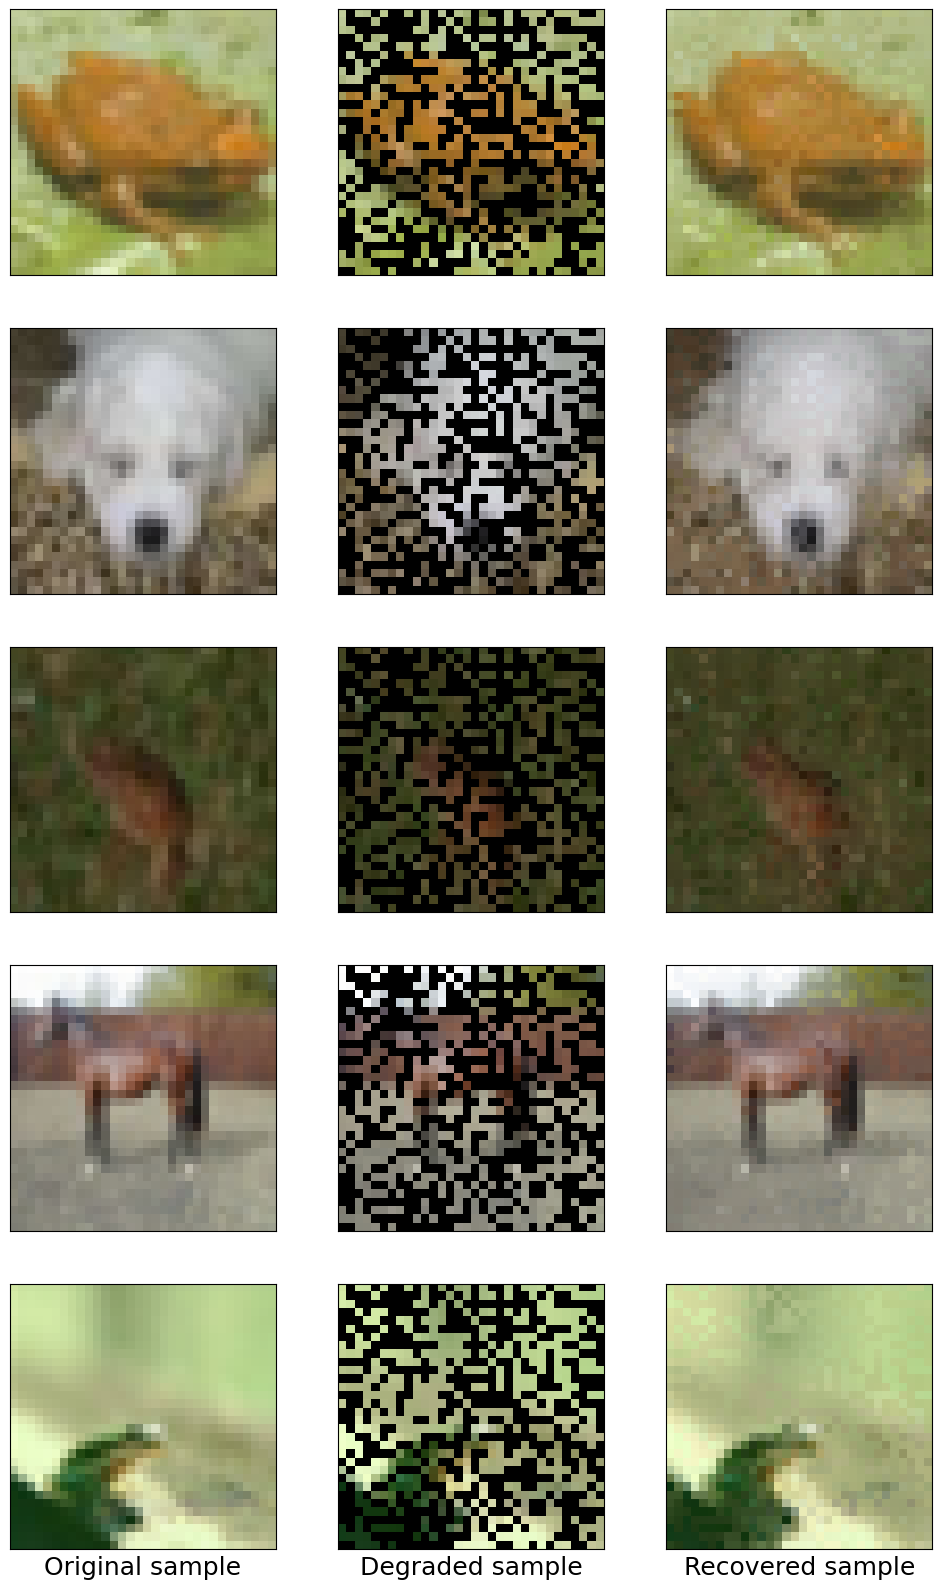

In [15]:
visualize_degradation(*get_random_mask(32,32,3),5)